<a href="https://colab.research.google.com/github/Xeesto/UEP/blob/main/Dane_Niezbilansowane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/creditcardfraud


SMOTE

In [8]:
from collections import Counter
from imblearn.over_sampling import SMOTE
import pandas as pd
from kagglehub import dataset_download
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
# Ściągnięcie danych
path = dataset_download("mlg-ulb/creditcardfraud")
file_path = path + "/creditcard.csv"

# Wczytanie do DataFrame
df = pd.read_csv(file_path)
print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

Rozkład klas:
Counter({0: 284315, 1: 492})


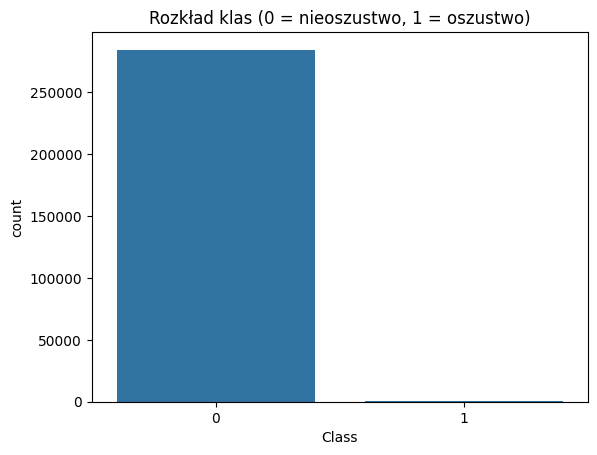

In [10]:
print("Rozkład klas:")
print(Counter(df['Class']))

sns.countplot(data=df, x='Class')
plt.title("Rozkład klas (0 = nieoszustwo, 1 = oszustwo)")
plt.show()

In [13]:
X = df.drop(columns=['Class'])
y = df['Class']

# Standaryzacja danych
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

In [12]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE(random_state=42)
X_train_os, y_train_os = oversample.fit_resample(X_train, y_train)

print("Rozkład klas po SMOTE:", Counter(y_train_os))

Rozkład klas po SMOTE: Counter({0: 199020, 1: 199020})


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.89      0.78      0.83       148

    accuracy                           1.00     85443
   macro avg       0.95      0.89      0.92     85443
weighted avg       1.00      1.00      1.00     85443



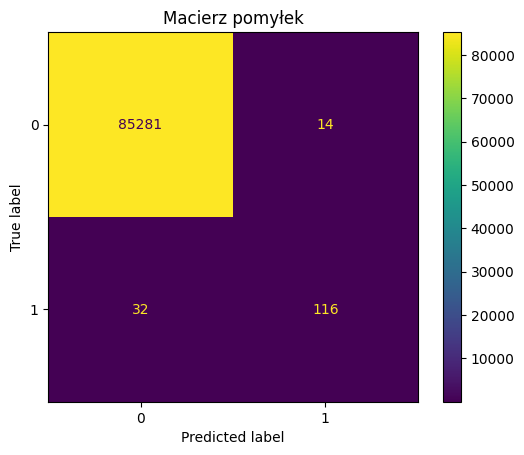

In [15]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_os, y_train_os)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

# Macierz pomyłek
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.title("Macierz pomyłek")
plt.show()

In [16]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9995


XGBoost

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier

In [21]:
X = df.drop(columns=['Class'])
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [22]:
# Skalowanie danych
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
# Smote oraz undersampling

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train_scaled, y_train)

under = RandomUnderSampler(random_state=42)
X_balanced, y_balanced = under.fit_resample(X_smote, y_smote)


KeyboardInterrupt: 

In [25]:
print("Nowy rozkład klas:", pd.Series(y_balanced).value_counts())

Nowy rozkład klas: Class
0    199020
1    199020
Name: count, dtype: int64


In [26]:
model = XGBClassifier(
    scale_pos_weight=5,  # ← do dostrojenia
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

In [27]:
model.fit(X_balanced, y_balanced)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:53:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Classification report:
              precision    recall  f1-score   support

           0     0.9996    0.9994    0.9995     85295
           1     0.6860    0.7973    0.7375       148

    accuracy                         0.9990     85443
   macro avg     0.8428    0.8983    0.8685     85443
weighted avg     0.9991    0.9990    0.9991     85443

Accuracy: 0.9990


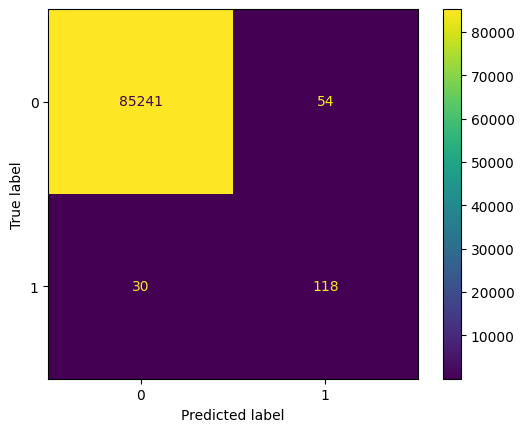

In [28]:
# Sprawdzenie danych

y_pred = model.predict(X_test_scaled)

print("Classification report:")
print(classification_report(y_test, y_pred, digits=4))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [29]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9990
